In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn as nn
from torch.optim import SGD as sgd # Stochastic Gradient Descent
from torch.optim import Adam as adam
import pandas as pd
import torchviz

import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

In [2]:
class CDataset(Dataset):
    def __init__(self, filepath):
        self.dataset = pd.read_csv(filepath)

        self.x = self.dataset.iloc[:, 1:].values  # all columns except the first one
        self.y = self.dataset.iloc[:, 0].values  # first column is the label

        # Reshape features into images (assuming images are 28x28 pixels)
        self.x = self.x.reshape(-1, 28, 28)

        # Convert to PyTorch tensors
        self.x = torch.tensor(self.x)
        self.y = torch.tensor(self.y)

        # TODO: Is this the right place for normalization? As this may affect the convolutional layers!
        # Normalize image pixels
        self.x = self.x / 255.0

        # Encoding labels into one-hot vectors
        self.y = F.one_hot(self.y, num_classes=10).to(float)

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, i):
        return self.x[i], self.y[i]

In [3]:
train_ds = CDataset("mnist_train.csv")
len(train_ds)

60000

In [4]:
test_ds = CDataset("mnist_test.csv")
len(test_ds)

10000

In [5]:
train_dl = DataLoader(train_ds, batch_size=5)

In [6]:
test_dl = DataLoader(test_ds, batch_size=5)

In [7]:
#
# ANN with 2 hidden layers using ReLU activation function with bias.
#

class NN1(nn.Module):
    def __init__(self):
        super().__init__()
        self.Matrix1 = nn.Linear(28**2, 100)
        self.Matrix2 = nn.Linear(100, 50)
        self.Matrix3 = nn.Linear(50, 10)
        
        self.R = nn.ReLU()

    def forward(self, x):
        # Converting images from matrices to vectors (AKA flattening)
        x = x.view(-1, 28**2)

        x = self.R(self.Matrix1(x))
        x = self.R(self.Matrix2(x))

        # TODO: Is this the right place for softmax?
        x = self.Matrix3(x)
        
        return x.squeeze()

In [8]:
# Train model function
def train_model(dl, nni, n_epochs=20, lr=0.01):
    # Optimization
    opt = adam(nni.parameters(), lr=lr)
    L = nn.MSELoss()

    # Train model
    losses = []
    epochs = []
    time_stamps = []

    start = time()

    # Loop over the dataset multiple times
    for epoch in range(n_epochs):
        print(f"Epoch {epoch}")
        N = len(dl) # 12'000 batches
        
        # Loop over all batches
        for i, (x, y) in enumerate(dl):
            # Update the weights of the network
            opt.zero_grad()

            # TODO: Why do we need to convert to float?
            x = x.to(torch.float32)  # Convert input data to Float
            y = y.to(torch.float32)  # Convert labels to Float

            loss_value = L(nni(x), y)
            loss_value.backward()
            opt.step()
            # Store training data for plotting
            epochs.append(epoch + i / N) # epochs.append(epoch + i / N)
            losses.append(loss_value.item())
            time_stamps.append(time() - start)

    return np.array(epochs), np.array(losses), np.array(time_stamps)

In [20]:
global_epochs_data = []
global_loss_data = []
global_time_stamps = []

nn1 = NN1()

In [25]:
if not nn1.training:
    nn1.train()

epoch_data, loss_data, time_stamps = train_model(train_dl, nn1, n_epochs=1)

global_epochs_data.extend(epoch_data.tolist())
global_loss_data.extend(loss_data.tolist())
global_time_stamps.extend(time_stamps.tolist())

Epoch 0


In [ ]:
plt.plot(epoch_data, loss_data)
plt.xlabel("Epoch Number")
plt.ylabel("MSE")
plt.title("MSE (per batch)")

In [26]:
epoch_data = epoch_data.reshape(20,-1).mean(axis=1)
loss_data = loss_data.reshape(20,-1).mean(axis=1)
time_stamps = time_stamps.reshape(20,-1).mean(axis=1)

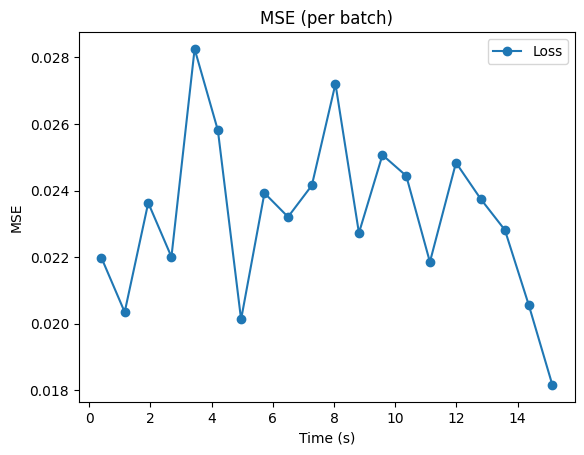

In [29]:
plt.plot(time_stamps, loss_data, marker='o', label='Loss')
plt.xlabel("Time (s)")
plt.ylabel("MSE")
plt.title("MSE (per batch)")
plt.legend()
# plt.savefig("plt.png")

In [28]:
correct_predictions = 0
total_samples = 0

# Set the model to evaluation mode
if nn1.training:
    nn1.eval()

# Iterate over the test data
with torch.no_grad():
    for x, y in test_dl:
        # Make predictions
        outputs = nn1(x)

        # Get predicted class labels
        predicted_labels = torch.argmax(outputs, dim=1)

        # Convert one-hot encoded labels to class indices
        y = torch.argmax(y, dim=1)
        
        # Compare predicted labels with actual labels
        correct_predictions += (predicted_labels == y).sum().item()
        total_samples += y.size(0)

# Calculate accuracy
accuracy = correct_predictions / total_samples

print(f"Loss: {loss_data[len(loss_data)-1]:.9f}")
print(f"Total samples: {total_samples}")
print(f"Correct predictions: {correct_predictions}")
print(f"Accuracy: {accuracy:.2%}")

Loss: 0.018163300
Total samples: 10000
Correct predictions: 8821
Accuracy: 88.21%
